<a href="https://colab.research.google.com/github/lauraveul1995/Assignments/blob/main/Copy_of_winc_assignment_gdp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setting up**

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.patches as mpatches
%load_ext google.colab.data_table

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/data

/content/drive/My Drive/data


# **Getting the data ready**

gdp data: https://lhendricks.org/econ821/growth/pwt.html

gini data: https://ourworldindata.org/income-inequality#high-income-countries-tend-to-have-lower-inequality

"RGDPE: to compare living standards (think: deflated by the consumer price index)"




In [ ]:
# reading in the data

gdp_data = pd.read_excel("pwt1001.xlsx",2)
gini_data = pd.read_csv("economic-inequality-gini-index.csv")

gdp_data = gdp_data.loc[:,["countrycode","country","year","rgdpe"]] # selecting only the relevant columns

gdp_data.columns = ["countrycode", "country", "year_rgdpe", "rgdpe"]
gini_data.columns = ["country", "countrycode", "year_gini", "gini_coef"]



In [ ]:
# small inspection

display((gdp_data["countrycode"].isna()==True).sum())
display((gini_data["countrycode"].isna()==True).sum())
# gini_data.loc[gini_data["countrycode"].isna()==True]
# gini_data.loc[gini_data["country"].str.contains("India")]

display(len(gdp_data["countrycode"].unique()))
display(len(gdp_data["year_rgdpe"].unique()))

display(len(gini_data["countrycode"].unique()))
display(len(gini_data["year_gini"].unique()))


I want to merge the two dataframes on countrycode (to prevent differences in country name from intervering) and year. In the gdp dataset, all countries have a countrycode. In the gini dataset, some countries/entries do not. Inspecting the data shows that this is because some countries have additional data based on the distinction between urban/rural. I will use only the information for the whole countries and in such select only the countries that have a countrycode available. In the gdp dataset, there is information for 183 countries and 70 years. In the gini dataset, it is a bit less with 167 countries and 50 years.

In [ ]:
# preparing data

gini_data = gini_data.loc[gini_data["countrycode"].isna()==False] # selecting countries with countrycodes

gini_gdp = pd.merge(gini_data, gdp_data,  how='left', left_on=['countrycode','year_gini'], right_on = ['countrycode','year_rgdpe']) # merging based on gini data: country code and available years

gini_gdp = gini_gdp.dropna(subset=["gini_coef","rgdpe"], how="any") # dropping rows with missing values on gini coef or rgdpe, as you need both to calculate correlation

gini_gdp = gini_gdp[gini_gdp['year_gini'].map(gini_gdp['year_gini'].value_counts()) > 2] # selecting years with more than 2 entries, as you need more than 2 entries to calculate a correlation that is not 1/-1

# **Results**

In [ ]:
# getting correlations

# gini_gdp.groupby('year_gini')[['gini_coef','rgdpe']].corr().unstack() # built in method, does not give p-values

correlations = gini_gdp.groupby('year_gini').apply(lambda x: pd.Series(pearsonr(x["gini_coef"],x["rgdpe"]), index=["corr", "pval"])) # scipi stats package, does give p-values
correlations.reset_index(inplace=True)
# group by year, for each year get the correlation and p-value for the relationship between the gini coefficient and gdp using pearsonr


Text(0.5, 1.0, 'Number of Countries Included in Each Year')

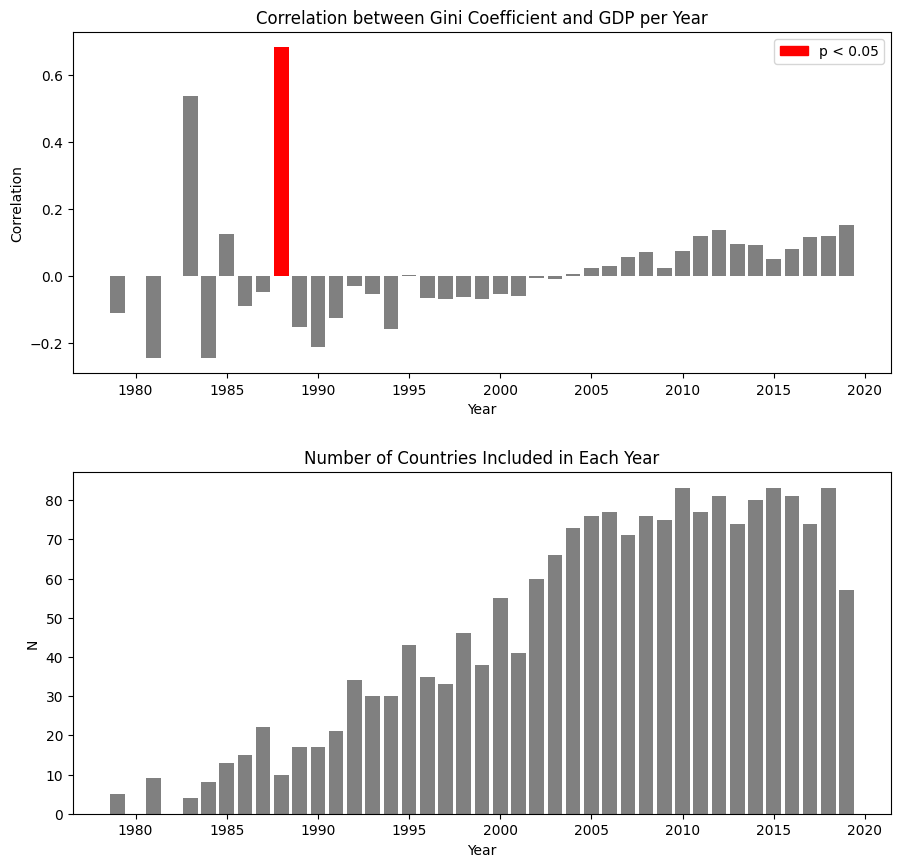

In [ ]:
# making an empty data format for the plot
d = {"x": range(1979,2019), "y": [0]*len(range(1979,2019))}
df = pd.DataFrame(data=d)

# getting a df for the counts (N)
counts = gini_gdp["year_gini"].value_counts()
df2 = pd.DataFrame(data=counts)
df2.reset_index(inplace=True)
df2.columns = ["year_gini", "counts"]


# plotting

f, [ax,ax2] = plt.subplots(2)
f.set_size_inches(10, 9.5)
f.tight_layout(pad=5.0)
ax.bar(df["x"], df["y"])
ax.bar(correlations["year_gini"], correlations["corr"], color="grey")
ax.bar(correlations["year_gini"][(correlations["pval"] < 0.05) & (correlations["pval"] > -0.05)], correlations["corr"][(correlations["pval"] < 0.05) & (correlations["pval"] > -0.05)], color="red")
red_patch = mpatches.Patch(color='red', label='p < 0.05')
ax.legend(handles=[red_patch])
ax.set_xlabel("Year")
ax.set_ylabel("Correlation")
ax.set_title("Correlation between Gini Coefficient and GDP per Year")
ax2.bar(df2["year_gini"], df2["counts"], color="grey")
ax2.set_xlabel("Year")
ax2.set_ylabel("N")
ax2.set_title("Number of Countries Included in Each Year")

# **Conclusion**

The correlations between the Gini coefficient and GDP are very erratic and differ alot across the years. The erratic pattern in the correlations that is seen especially in the early years can possibly be explained by the small number of countries for which information was available. In such, the correlations could have been heavily influenced by outliers and overall just not be very reliable and stable. One correlation (1988) was significant (p < 0.05) at a p-value of 0.029, but when taking into consideration the multiple testing (39 correlations calculated) done in this explorative assignment, we would want to correct for that and this correlation would also no longer hold statistical significance. The erratic pattern seems to stabilize somewhat with the more consistent availability of more country observations in the later years, but none of the correlations have any statistical significance. In such, I would not be comfortable stating that there is a relationship between the Gini coefficient and GDP.